In [1]:
# Sample API
import mae6225
import simulation
mae6225.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 40, 40
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0

Re   = 100
dt   = 0.001
tmax = 10.

# Define cell-centered variable names
center_vars = ['pres', 'divc']
face_vars   = ['velc', 'conv', 'diff']

# Define boundary conditions for variable pressure and velocity
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [0.0, 0.0, 0.0, 1.0]}

bc_type_v = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}


# Create the grid and data
gridc = mae6225.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = mae6225.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = mae6225.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

In [3]:
t = 0.0

while(t<=tmax):
    
    mae6225.ins.predictor(gridx, gridy, 'velc', 'conv', 'diff', Re, dt)
    
    mae6225.ins.divergence(gridc, gridx, gridy, 'velc', 'divc')
    
    ites, res = mae6225.poisson.solve_jacobi(gridc, 'pres', 'divc',
                                         maxiter=10000, tol=1e-9, verbose=True)
    
    mae6225.ins.corrector(gridc, gridx, gridy, 'velc', 'pres', dt)
    
    t = t+dt
    

Jacobi method:
- Number of iterations: 1
- Final residual: 0.0
Jacobi method:
- Number of iterations: 3820
- Final residual: 9.995688135983241e-10
Jacobi method:
- Number of iterations: 3802
- Final residual: 9.98582187821577e-10
Jacobi method:
- Number of iterations: 3782
- Final residual: 9.985009685820426e-10
Jacobi method:
- Number of iterations: 3762
- Final residual: 9.989979403588612e-10
Jacobi method:
- Number of iterations: 3743
- Final residual: 9.985298856839475e-10
Jacobi method:
- Number of iterations: 3724
- Final residual: 9.986302693593574e-10
Jacobi method:
- Number of iterations: 3705
- Final residual: 9.993011978197213e-10
Jacobi method:
- Number of iterations: 3687
- Final residual: 9.989983240021117e-10
Jacobi method:
- Number of iterations: 3669
- Final residual: 9.99259939082917e-10
Jacobi method:
- Number of iterations: 3652
- Final residual: 9.986996673480621e-10
Jacobi method:
- Number of iterations: 3638
- Final residual: 9.996813834069811e-10
Jacobi method:


/Users/Akash/Documents/Teaching/MAE-6225/mae6225/poisson/jacobi.py:53: RuntimeWarning: overflow encountered in square
  phi_old)**2) /


KeyboardInterrupt: 

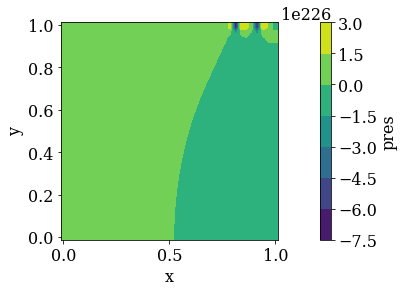

In [4]:
# Plot the analytical solution
mae6225.io.plot_contour(gridc, 'pres')